# **Connecto to GG Drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Shareddrives/DKD/GAN/MVTec-AD/Skip-Ganomaly-Screw'
! ls 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/DKD/GAN/MVTec-AD/Skip-Ganomaly-Screw
'Confusion matrix_cm.png'   name_model_roc_curve.png
 Discriminator128_20_500    pre_rec_curve.png
 Generator_128_20_200	    screw
 Generator_128_20_5	    screw.tar.xz
 Generator_128_20_500	    Skip-GANomaly.ipynb
 iscriminator128_20_200     TestNormalized_Skip-GANomaly.ipynb
 iscriminator128_20_5	    Untitled0.ipynb


# **Data Preprocessing**

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

**Data Info**

In [ ]:
image_size = 128
channels = 1
batch_size = 20
test_batch_size = 160
epoches = 1

**Training Dataset Processing**

In [ ]:
path =  "screw/train/good/" #path of training data

#To create a dataset of all files matching a pattern, 
#use tf.data.Dataset.list_files:
ds_train = tf.data.Dataset.list_files(str(pathlib.Path(path+ '*.png')))
for data in ds_train.take(1):
  print(data.numpy().decode('utf-8'))

screw/train/good/189.png


In [ ]:
def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.resize(image,(image_size, image_size))
    image = image/ 255
    label = 1
    return image, label

In [ ]:
#Using map and batch for train dataset
ds_train = ds_train.map(process_path).batch(batch_size)

(20, 128, 128, 1)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(20,), dtype=int32)


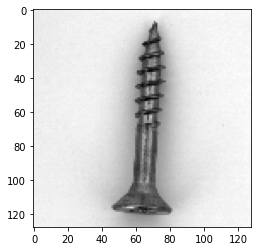

In [ ]:
#Show the image, label
for x, y in ds_train.take(1):
  print(x.shape) # 20 images, size 128x128, channels = 1
  print(y)
  arr = np.squeeze(x[0])
  imshow(arr, cmap = 'gray')

**Testing Data Processing**

In [ ]:
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = 'screw/test/',
    labels = 'inferred',
    label_mode = 'int', 
    color_mode = 'grayscale',
    batch_size = test_batch_size,
    image_size = (image_size,image_size),
    shuffle = True,
    seed = 123,
)

Found 160 files belonging to 2 classes.


In [ ]:
def process_test(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [ ]:
ds_test = ds_test.map(process_test)

In [ ]:
#Test test_data
for x, y in ds_test:
  print(x.shape)
  print(x[0])

(160, 128, 128, 1)
tf.Tensor(
[[[0.8245098 ]
  [0.8215686 ]
  [0.8127451 ]
  ...
  [0.8509804 ]
  [0.845098  ]
  [0.85490197]]

 [[0.8215686 ]
  [0.8098039 ]
  [0.8215686 ]
  ...
  [0.84313726]
  [0.8568627 ]
  [0.8509804 ]]

 [[0.8382353 ]
  [0.8186275 ]
  [0.8137255 ]
  ...
  [0.8539216 ]
  [0.85588235]
  [0.8401961 ]]

 ...

 [[0.8480392 ]
  [0.8382353 ]
  [0.8372549 ]
  ...
  [0.8147059 ]
  [0.81960785]
  [0.8127451 ]]

 [[0.8480392 ]
  [0.84313726]
  [0.8480392 ]
  ...
  [0.82941175]
  [0.8137255 ]
  [0.81666666]]

 [[0.8362745 ]
  [0.8401961 ]
  [0.8509804 ]
  ...
  [0.8186275 ]
  [0.83137256]
  [0.83235294]]], shape=(128, 128, 1), dtype=float32)


# **Custom Layers**

In [ ]:
from tensorflow.keras import layers

**Conv_block**

In [ ]:
class Conv_block(tf.keras.Model):

    def __init__(self, num_filters):
        super(Conv_block,self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(filters = num_filters, 
                          kernel_size=3,
                          strides = 2,
                          padding = 'same',
                          use_bias = False,
                          kernel_initializer = tf.random_normal_initializer(0., 0.02)),

            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

        ])

    def call(self, inputs, training= False):
        outputs = self.conv_layer(inputs)

        return outputs

**Conv_T_block**

In [ ]:
class Conv_T_block(tf.keras.Model):

    def __init__(self, num_filters):
        super(Conv_T_block,self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(filters=num_filters,
                                   kernel_size = 3,
                                   strides = 2,
                                   padding = 'same',
                                   use_bias = False,
                                   kernel_initializer = tf.random_normal_initializer(0., 0.02)
                                ),
            layers.BatchNormalization(),
            layers.ReLU(),     
                                                
        ])
    
    def call(self, inputs, concat, training = False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)

        return outputs


# **Model**

**Generator**

In [ ]:
# class Generator(tf.keras.Model):
#     def __init__(self, num_output_channels=3):
#         super(Generator, self).__init__()
#         self.encoder_1 = Conv_block(64) # 16
#         self.encoder_2 = Conv_block(128) # 8
#         self.encoder_3 = Conv_block(256) # 4
#         self.encoder_4 = Conv_block(512) # 2
        
#         self.center = Conv_block(512) # 1
        
#         self.decoder_4 = Conv_T_block(512) # 2
#         self.decoder_3 = Conv_T_block(256) # 4
#         self.decoder_2 = Conv_T_block(128) # 8
#         self.decoder_1 = Conv_T_block(64) # 16
        
#         self.output_layer = layers.Conv2DTranspose(num_output_channels, 1, strides=2, padding='same', use_bias=False, # 32
#                                                    kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
#     def call(self, inputs, training=False):
#         en_1 = self.encoder_1(inputs) # gen
#         en_2 = self.encoder_2(en_1)
#         en_3 = self.encoder_3(en_2)
#         en_4 = self.encoder_4(en_3)
        
#         center = self.center(en_4)
        
#         de_4 = self.decoder_4(center, en_4)
#         de_3 = self.decoder_3(de_4, en_3)
#         de_2 = self.decoder_2(de_3, en_2)
#         de_1 = self.decoder_1(de_2, en_1)
        
#         outputs = self.output_layer(de_1)
        
#         return outputs


In [ ]:
class Generator(tf.keras.Model):

    def __init__(self, num_output_channels):
        super(Generator,self).__init__()
        self.encoder_1 = Conv_block(64)
        self.encoder_2 = Conv_block(128)
        self.encoder_3 = Conv_block(256)
        self.encoder_4 = Conv_block(512)

        self.center = Conv_block(512)

        self.decoder_4 = Conv_T_block(512)
        self.decoder_3 = Conv_T_block(256)
        self.decoder_2 = Conv_T_block(128)
        self.decoder_1 = Conv_T_block(64)

        self.output_layer = layers.Conv2DTranspose(filters = num_output_channels,
                                                   kernel_size = 1,
                                                   strides = 2, 
                                                   padding = 'same',
                                                   use_bias = False,
                                                   kernel_initializer = tf.random_normal_initializer(0., 0.02))
    

    def call(self, inputs, training = False):
        en_1 = self.encoder_1(inputs)
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)

        center = self.center(en_4)

        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)

        outputs = self.output_layer(de_1)

        return outputs

**Discriminator**

In [ ]:
class Discriminator(tf.keras.Model):

    def __init__(self):
        super(Discriminator,self).__init__()
        self.encoder_1 = Conv_block(64)
        self.encoder_2 = Conv_block(128)
        self.encoder_3 = Conv_block(256)
        self.encoder_4 = Conv_block(512)

        self.center = Conv_block(100)

        self.output_layer = layers.Conv2D(filters = 1,
                                          kernel_size = 3,
                                          strides = 1,
                                          padding = 'same',
                                          use_bias = False,
                                          activation = 'sigmoid')
    

    def call(self, inputs, training = False):
        en_1 = self.encoder_1(inputs)
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)

        center = self.center(en_4)

        outputs = self.output_layer(center)

        return outputs, center

# **Losses Function**

In [ ]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5

    return total_dis_loss

In [ ]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1
    w_context = 40
    w_encoder = 1

    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first,latent_sec)

    total_gen_loss =    w_adv * adv_loss + \
                        w_context * context_loss + \
                        w_encoder * encoder_loss

    return total_gen_loss

# **Optimizers**

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

# **Trainer**

In [ ]:
generator = Generator(num_output_channels=1)
discriminator = Discriminator()

In [ ]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training = True)

        pred_real, feat_real = discriminator(images, training = True)
        pred_fake, feat_fake = discriminator(generated_images, training = True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real,feat_fake)
        
        disc_loss = discriminator_loss(pred_real, pred_fake)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
from tqdm import tqdm  # For nice progress bar!
import time 

steps = 0

for epoch in range(epoches):
    start = time.time()

    for images, labels in tqdm(ds_train):
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Time for epoch 1 is 3.7730424404144287 sec
